# Exploratory Data Analysis: Lichess database

This jupyter notebook contains an exploratory data analysis done over a chess database with information from 200k games. Each game (the rows of the data frame) contains categorical variates, such as the type of opening (ECO), and numerical variates, such as the elo of each player.

The main objective of this EDA was to determine the statistical relations between many of the variates in order to establish whether the dataset is suitable for machine learning (ML) or not. Furthermore, the size of the dataset permitted the execution of more precise hypothesis testing meaning that, overall, many of the tests resulted in p-values below the established threshold. In that sense, data visualization techniques provided greater insight to determine if the statistical significance predicted by the tests was relevant.

### Remarks

1. In general, the notebook has the following structure: markdown cell --> code cells.

2. Each code cell includes hashed text explaining briefly what the code is supposed to be doing. Additional commentary is contained in the markdown cells.

3. All the required libraries are included in the first code cell, namely the preamble of the notebook. Exceptions include particular ```scipy``` submodules used for miscellaneous statistics calculations.

4. **All the graphs** contained in this notebook are saved in the ```graphs``` directory.

5. The dataset is available in the github repository as ```modified_dataset```.

In [243]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [244]:
# Loading dataset
games_df = pd.read_csv('modified_dataset', delimiter = ',')
games_df.drop('index', inplace = True, axis = 1)
games_df

,BlackElo,BlackRatingDiff,Date,ECO,Result,Termination,UTCTime,WhiteElo,WhiteRatingDiff,BlackTitle,WhiteTitle,Category,Weekday,Movements
0,906,13.0,2019.04.30,B15,0-1,Normal,22:00:24,971,-12.0,NaN,NaN,Blitz,Tuesday,73
1,1296,28.0,2019.04.30,C50,0-1,Normal,22:00:13,1312,-10.0,NaN,NaN,Blitz,Tuesday,67
2,1761,-13.0,2019.04.30,C41,1-0,Normal,22:00:41,1653,27.0,NaN,NaN,Rapid,Tuesday,71
3,2404,8.0,2019.04.30,B06,0-1,Normal,22:00:43,2324,-8.0,NaN,FM,Bullet,Tuesday,85
4,1595,-10.0,2019.04.30,B32,1-0,Normal,22:00:46,1614,29.0,NaN,NaN,Blitz,Tuesday,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1491,10.0,2019.05.22,B00,0-1,Normal,21:17:00,1456,-9.0,NaN,NaN,Rapid,Wednesday,30
199996,1549,-10.0,2019.05.22,C21,1-0,Time forfeit,21:17:09,1575,25.0,NaN,NaN,Classical,Wednesday,59
199997,1450,-11.0,2019.05.22,D20,1-0,Normal,21:17:09,1439,11.0,NaN,NaN,Blitz,Wednesday,42
199998,1588,40.0,2019.05.22,B07,0-1,Normal,21:17:13,1753,-18.0,NaN,NaN,Bullet,Wednesday,45


In [245]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BlackElo         200000 non-null  int64  
 1   BlackRatingDiff  199491 non-null  float64
 2   Date             200000 non-null  object 
 3   ECO              200000 non-null  object 
 4   Result           200000 non-null  object 
 5   Termination      200000 non-null  object 
 6   UTCTime          200000 non-null  object 
 7   WhiteElo         200000 non-null  int64  
 8   WhiteRatingDiff  199491 non-null  float64
 9   BlackTitle       810 non-null     object 
 10  WhiteTitle       784 non-null     object 
 11  Category         200000 non-null  object 
 12  Weekday          200000 non-null  object 
 13  Movements        200000 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 21.4+ MB


## Goodness of fit test for Elo distribution

$H_0$: Average Elo data is beta distributed.

$H_1$: Average Elo data deviaties from a beta distribution.

In [246]:
from scipy import stats
from functools import partial
from sklearn.utils import resample

avg_elo = (games_df['WhiteElo'] + games_df['BlackElo'])/2 # Calculates average elo of each game
data = avg_elo
re_data = resample(data, replace = True, n_samples = 7500, random_state = 23490) # Resampling
beta_param_bounds = [(4,5),(7,9),(600, 700),(2400,2500)] # Prepares bounds for the a, b, loc, and scale parameters of the beta fit.
fit_result = stats.fit(stats.beta, re_data, beta_param_bounds) # Gives results of the fit
a, b, loc, scale = fit_result.params 
beta_fit = stats.beta(a, b, loc, scale) # Distribution that fits the data best
m, v , s, k = beta_fit.stats(moments = 'mvsk')
print('Mean value: {}'.format(m))
print('Variance: {}'.format(v))
print('Skewness: {}'.format(s))
print('Kurtosis: {}'.format(k))

Mean value: 1512.9965078931632
Variance: 99448.54452319095
Skewness: 0.2614540231570991
Kurtosis: -0.28448114283921033


In [247]:
# Kolmogorov - Smirnov test
D_stat, p_value = stats.kstest(re_data, partial(stats.beta.cdf, a = a, b = b, loc = loc, scale = scale))
print('Maximum function difference (KS test statistic) = {}'.format(D_stat))
print('p value = {}'.format(p_value))
alpha = 0.05
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

Maximum function difference (KS test statistic) = 0.011518082660390894
p value = 0.2706246572355756
The null hypothesis is not rejected.


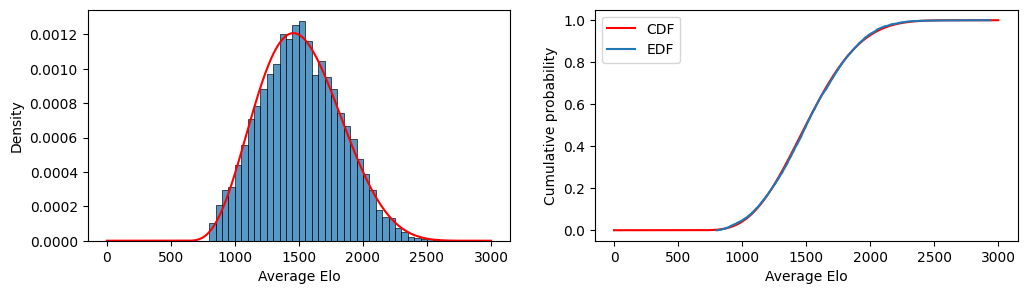

In [248]:
fig, axes = plt.subplots(1, 2, figsize = (12, 3)) # Definition of graphing instances

x = np.linspace(0, 3000, 10000) # Graphing range

pdf = beta_fit.pdf(x) # Probability density function
cdf = beta_fit.cdf(x) # Cumulative distribution function

axes[0].plot(x, pdf, color = 'r', label = 'Fit') # Graphs PDF
sns.histplot(re_data, ax = axes[0], stat = 'density',binwidth = 50, label = 'Data') # Graphs histogram of data

N = 7500 # Number of games
sorted_data = np.sort(re_data) # Ordered data
edf = np.arange(N) / float(N) # 'Experimental' cumulative distribution function

axes[1].plot(x, cdf, color = 'r', label = 'CDF') # Graphs CDF
axes[1].plot(sorted_data, edf, label = 'EDF') # Graphs EDF

for ax in axes.flat:
    ax.set(xlabel = 'Average Elo')

axes[1].set(ylabel = 'Cumulative probability')
plt.legend()
plt.savefig('graphs/kstest-avg_elo.pdf', dpi = 700, bbox_inches = 'tight')

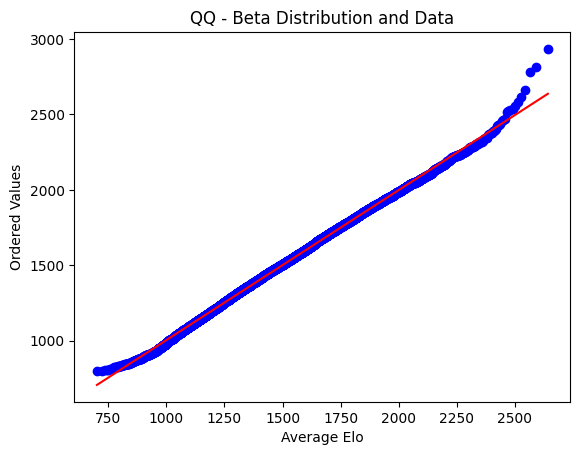

In [249]:
# q-q graph
qq_fig = plt.figure()
ax = qq_fig.add_subplot(111)
stats.probplot(re_data, dist=beta_fit, plot=ax)
ax.set_xlabel('Average Elo')
ax.set_title('QQ - Beta Distribution and Data')
plt.savefig('graphs/qq_avg_elo.pdf', bbox_inches = 'tight')

## Goodness of fit test for Elo distribution (Categorical)

As a continuation of the previous test, a $\chi^2$-GOF test is performed over a categorical division of elo, namely: low elo, mid elo, high elo, and very high elo. The fitted distribution is numerically integrated over the required intervals in order to obtain the expected frequencies.

### Intervals

- Low elo if $elo \leq 1400$
- Mid elo if $1400 < elo \leq 1800$
- High elo if $1800 < elo \leq 2000$
- Very high elo if $2000 < elo$

In [250]:
# Elo dataframe (categorical)
elo = pd.DataFrame(avg_elo, columns = ['AverageElo'])
elo['EloTier'] = ['Very high elo' if elo >= 2000 else 'High elo' if elo >= 1800 else \
    'Mid elo' if elo >= 1400 else 'Low elo' for elo in avg_elo]
re_elo = resample(elo, replace = True, n_samples = 7500, random_state = 23490)
re_elo = re_elo.reset_index(drop = True)
re_elo

,AverageElo,EloTier
0,1671.5,Mid elo
1,1909.0,High elo
2,1695.5,Mid elo
3,1202.5,Low elo
4,1420.0,Mid elo
...,...,...
7495,1647.0,Mid elo
7496,1807.5,High elo
7497,1117.5,Low elo
7498,1841.5,High elo


In [251]:
import scipy.integrate as integrate

# Integration
intervals = [(-np.inf, 1400), (1400, 1800), (1800, 2000), (2000, np.inf)]
probabilities_exp = []
for i in intervals:
    probabilities_exp.append(integrate.quad(lambda x: beta_fit.pdf(x), i[0], i[1])[0])

# Counts
observed = re_elo['EloTier'].value_counts(normalize = True)
probabilities_obs = [observed['Low elo'], observed['Mid elo'], observed['High elo'], observed['Very high elo']]

# chi-squared test
chi_stat, p_value = stats.chisquare(probabilities_obs, probabilities_exp)
print('chi statistic = {}'.format(chi_stat))
print('p value = {}'.format(p_value))
alpha = 0.05
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

chi statistic = 0.0011361156799701416
p value = 0.9999898186675287
The null hypothesis is not rejected.


## ANOVA test: Number of moves and opening

Each game is grouped in one of five categories according to the first letter of ECO.

$H_0$: The mean number of moves for each of the groups is the same.

$H_1$: At least one group has a different mean number of moves.

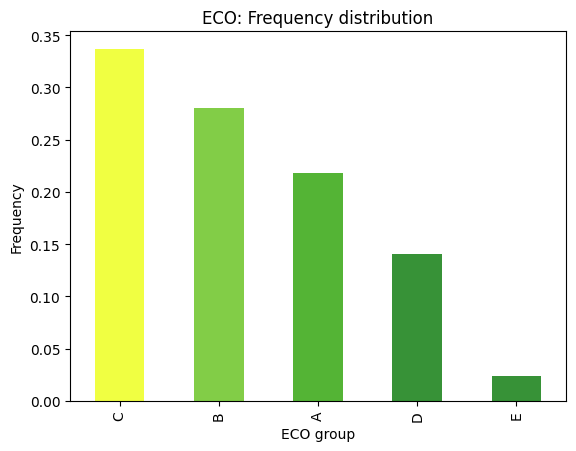

In [252]:
# Creating group dataframe and checking for imbalance
group = pd.DataFrame(games_df['ECO'].str[0])
group['Movements'] = games_df['Movements']
group['ECO'].value_counts(normalize = True).plot.bar(color = ['#F0FF42', '#82CD47', '#54B435', '#379237', '#379237'])
group.value_counts()
plt.title(r'ECO: Frequency distribution')
plt.ylabel('Frequency')
plt.xlabel('ECO group')
plt.savefig('graphs/Frequency_ECO.pdf', bbox_inches = 'tight')

As can be seen from the counts histogram above, the data is imbalanced. In order to correct this, the groups will be downsampled to 1500 observations each.

In [253]:
# Individual dataframes for each group
df_A = group[(group['ECO'] == 'A')]
df_B = group[(group['ECO'] == 'B')]
df_C = group[(group['ECO'] == 'C')]
df_D = group[(group['ECO'] == 'D')]
df_E = group[(group['ECO'] == 'E')]

# Resampling
re_A = resample(df_A, n_samples = 1500, random_state = 23490)
re_B = resample(df_B, n_samples = 1500, random_state = 23490)
re_C = resample(df_C, n_samples = 1500, random_state = 23490)
re_D = resample(df_D, n_samples = 1500, random_state = 23490)
re_E = resample(df_E, n_samples = 1500, random_state = 23490)

# Resampled group dataframe
re_group = pd.concat([re_A, re_B, re_C, re_D, re_E])
re_group = re_group.reset_index(drop = True)
re_group

,ECO,Movements
0,A,62
1,A,65
2,A,48
3,A,43
4,A,43
...,...,...
7495,E,47
7496,E,80
7497,E,66
7498,E,95


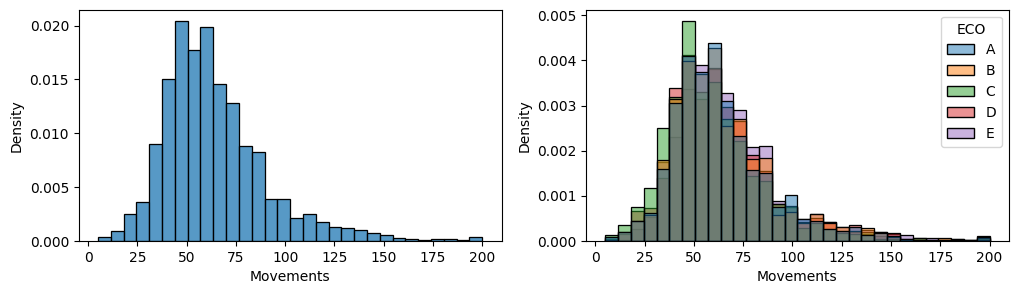

In [254]:
fig, axes = plt.subplots(1, 2, figsize = (12, 3))
sns.histplot(re_group, x = 'Movements', stat = 'density', bins = 30, ax = axes[0])
sns.histplot(re_group, x = 'Movements', stat = 'density', bins = 30, hue = 'ECO', ax = axes[1])
plt.savefig('graphs/distribution_moves.pdf', bbox_inches = 'tight')

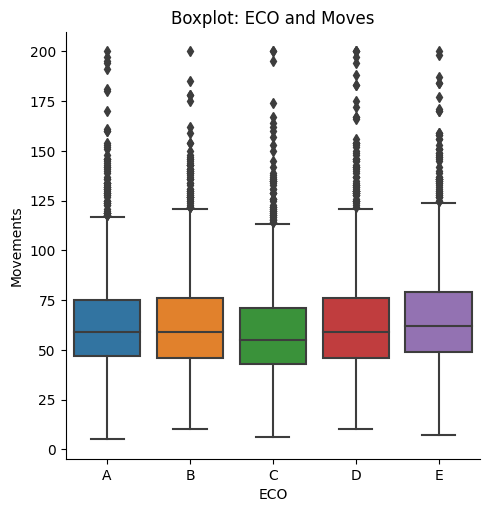

In [255]:
sns.catplot(data = re_group, x = 'ECO', y = 'Movements', kind = 'box')
plt.title('Boxplot: ECO and Moves')
plt.savefig('graphs/boxplot_eco_moves.pdf', bbox_inches = 'tight')

In [256]:
# Grouping
groups = re_group.groupby('ECO').groups
A = re_group['Movements'][groups['A']]
B = re_group['Movements'][groups['B']]
C = re_group['Movements'][groups['C']]
D = re_group['Movements'][groups['D']]
E = re_group['Movements'][groups['E']]

# log transformation
A_log = np.log(A)
B_log = np.log(B)
C_log = np.log(C)
D_log = np.log(D)
E_log = np.log(E)

# ANOVA
f_stat, p_value = stats.f_oneway(A_log, B_log, C_log, D_log, E_log)
print('F statistic = {}'.format(f_stat))
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

F statistic = 21.665848096505243
p-value = 8.532681030482333e-18
The null hypothesis is rejected.


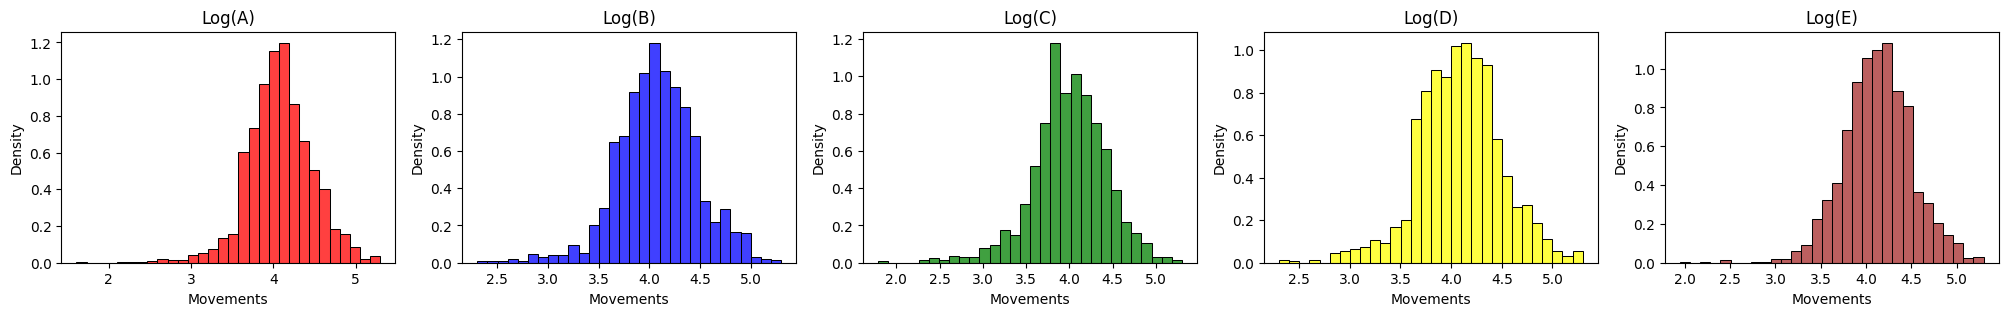

In [257]:
fig, axes = plt.subplots(1,5, figsize = (25,3))
sns.histplot(A_log, stat = 'density', ax = axes[0], color = 'red', bins = 30)
sns.histplot(B_log, stat = 'density', ax = axes[1], color = 'blue', bins = 30)
sns.histplot(C_log, stat = 'density', ax = axes[2], color = 'green', bins = 30)
sns.histplot(D_log, stat = 'density', ax = axes[3], color = 'yellow', bins = 30)
sns.histplot(E_log, stat = 'density', ax = axes[4], color = 'brown', bins = 30)
axes[0].set_title('Log(A)')
axes[1].set_title('Log(B)')
axes[2].set_title('Log(C)')
axes[3].set_title('Log(D)')
axes[4].set_title('Log(E)')
plt.savefig('graphs/log_eco.pdf', bbox_inches = 'tight')

## ANOVA test: Movements and type of game

Each game is grouped in one of 4 types of game according to Category.

$H_0$: The mean number of movements is the same for all the categories.

$H_1$: At least one category has a different mean number of movements.

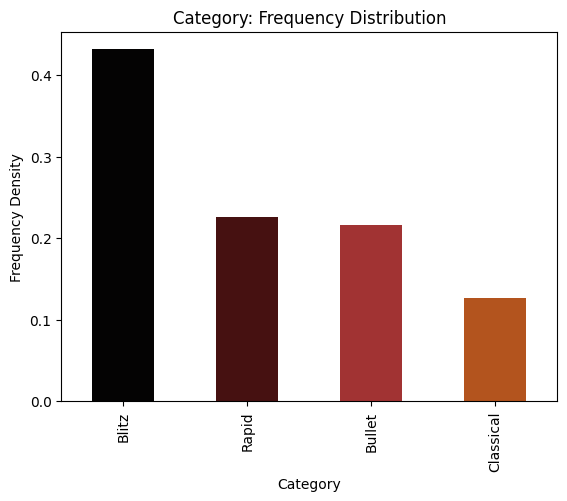

In [258]:
# DataFrame and imbalance
category = games_df[['Movements', 'Category']]
category['Category'].value_counts(normalize = True).plot.bar(color = ['#040303', '#461111', '#A13333', '#B3541E'])
category['Category'].value_counts()
plt.xlabel('Category')
plt.ylabel('Frequency Density')
plt.title('Category: Frequency Distribution')
plt.savefig('graphs/category_freq.pdf', bbox_inches = 'tight')

In [259]:
# Individual dataframes for each group
df_blitz = category[(category['Category'] == 'Blitz')]
df_rapid = category[(category['Category'] == 'Rapid')]
df_bullet = category[(category['Category'] == 'Bullet')]
df_classical = category[(category['Category'] == 'Classical')]

# Resampling
re_blitz = resample(df_blitz, n_samples = 1875, random_state = 23490)
re_rapid = resample(df_rapid, n_samples = 1875, random_state = 23490)
re_bullet = resample(df_bullet, n_samples = 1875, random_state = 23490)
re_classical = resample(df_classical, n_samples = 1875, random_state = 23490)

# Resampled group dataframe
re_category = pd.concat([re_blitz, re_rapid, re_bullet, re_classical])
re_category = re_category.reset_index(drop = True)
re_category

,Movements,Category
0,36,Blitz
1,83,Blitz
2,46,Blitz
3,70,Blitz
4,67,Blitz
...,...,...
7495,63,Classical
7496,58,Classical
7497,109,Classical
7498,56,Classical


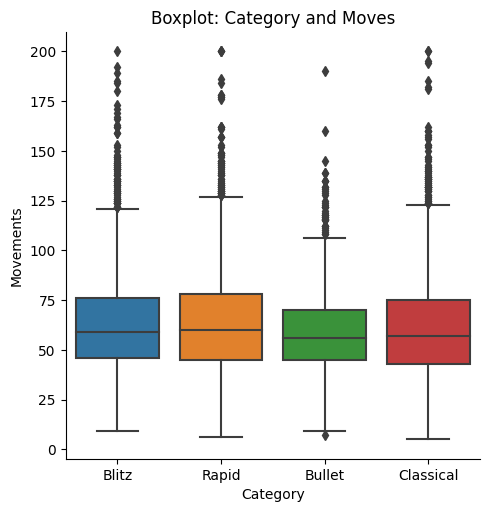

In [260]:
sns.catplot(data = re_category, x = 'Category', y = 'Movements', kind = 'box')
plt.title('Boxplot: Category and Moves')
plt.savefig('graphs/boxplot_category_moves.pdf', bbox_inches = 'tight')

In [261]:
# Grouping
categories = re_category.groupby('Category').groups
blitz = re_category['Movements'][categories['Blitz']]
rapid = re_category['Movements'][categories['Rapid']]
bullet = re_category['Movements'][categories['Bullet']]
classical = re_category['Movements'][categories['Classical']]

# log transformation
blitz_log = np.log(blitz)
rapid_log = np.log(rapid)
bullet_log = np.log(bullet)
classical_log = np.log(classical)

# ANOVA
f_stat, p_value = stats.f_oneway(blitz_log, rapid_log, bullet_log, classical_log)
print('F statistic = {}'.format(f_stat))
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

F statistic = 7.779036975023016
p-value = 3.4926029268274264e-05
The null hypothesis is rejected.


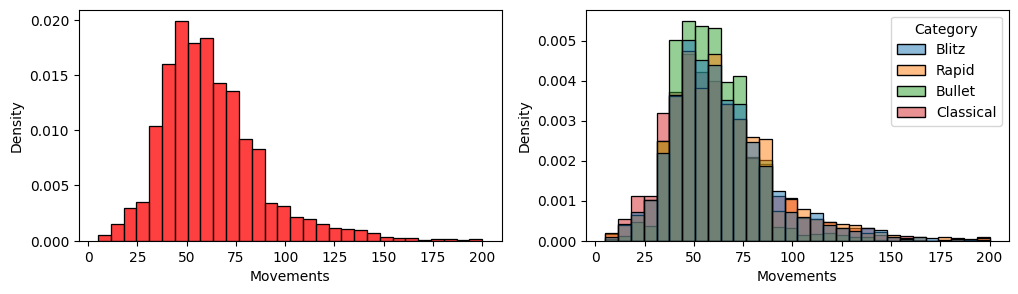

In [262]:
fig, axes = plt.subplots(1, 2, figsize = (12,3))
sns.histplot(re_category, x = 'Movements', stat = 'density', bins = 30, color = 'red', ax = axes[0])
sns.histplot(re_category, x = 'Movements', stat = 'density', bins = 30, hue = 'Category', ax = axes[1])
plt.savefig('graphs/distribution_moves_category.pdf', bbox_inches = 'tight')

## Statistical independence: Elo range and Opening

A $\chi ^ 2$-test is used to determine if the categorical variates EloTier and ECO are statistically independent.

$H_0$: The variates are independent.

$H_1$: The variates are dependent.

In [263]:
group['EloTier'] = elo['EloTier']
elo_op = group.drop('Movements', axis = 1)

# Individual dataframes for each group
df_low = elo_op[(elo_op['EloTier'] == 'Low elo')]
df_mid = elo_op[(elo_op['EloTier'] == 'Mid elo')]
df_high = elo_op[(elo_op['EloTier'] == 'High elo')]
df_vhigh = elo_op[(elo_op['EloTier'] == 'Very high elo')]

# Resampling
re_low = resample(df_low, n_samples = 1500, random_state = 23490)
re_mid = resample(df_mid, n_samples = 1500, random_state = 23490)
re_high = resample(df_high, n_samples = 1500, random_state = 23490)
re_vhigh = resample(df_vhigh, n_samples = 1500, random_state = 23490)

# Resampled dataframe
re_elo_op = pd.concat([re_low, re_mid, re_high, re_vhigh])
re_elo_op = re_elo_op.reset_index(drop = True)

# Contingency table
ct_ind = pd.crosstab(re_elo_op['ECO'], re_elo_op['EloTier'])
print(ct_ind)

EloTier  High elo  Low elo  Mid elo  Very high elo
ECO                                               
A             373      297      346            464
B             492      348      427            502
C             340      594      513            263
D             237      246      183            198
E              58       15       31             73


In [264]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(ct_ind)
print('chi2 statistic = {}'.format(chi2_stat))
print('p-value = {}'.format(p_value))
print('# degrees of freedom = {}'.format(dof))

if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

chi2 statistic = 296.3056073976459
p-value = 2.8004547989071422e-56
# degrees of freedom = 12
The null hypothesis is rejected.


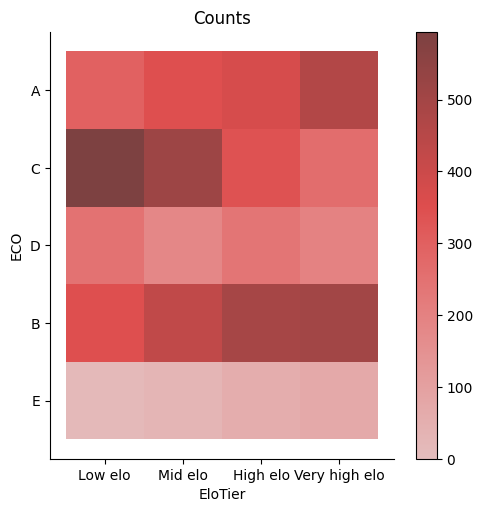

In [265]:
sns.displot(data = re_elo_op, x = 'EloTier', y = 'ECO', cbar = True, color = '#461111')
plt.title('Counts')
plt.savefig('graphs/counts_eco_elo.pdf', bbox_inches = 'tight')

## $\chi^2$ test: Result and Elo range

Each game is classified in one of 4 tiers of elo according to the mean elo between black and white: low elo, mid elo, high elo, very high elo.

$H_0$: There is no substantial relationship between the EloTier and Result variates.

$H_1$: There is a substantial relationship between the EloTier and Result variates.

In [266]:
import scipy.stats
from sklearn.utils import resample
from scipy.stats import chi2_contingency

games_df['EloTier'] = ['Very high elo' if elo >= 2000 else 'High elo' if elo >= 1800 else \
    'Mid elo' if elo >= 1400 else 'Low elo' for elo in avg_elo] #Create a new EloTier column
games_df['Result'].replace({'0-1': 'Lose', '1/2-1/2': 'Draw', '*': np.NAN, '1-0': 'Win'}, inplace = True) #Replace the numeric with categorical variables
games_df

,BlackElo,BlackRatingDiff,Date,ECO,Result,Termination,UTCTime,WhiteElo,WhiteRatingDiff,BlackTitle,WhiteTitle,Category,Weekday,Movements,EloTier
0,906,13.0,2019.04.30,B15,Lose,Normal,22:00:24,971,-12.0,NaN,NaN,Blitz,Tuesday,73,Low elo
1,1296,28.0,2019.04.30,C50,Lose,Normal,22:00:13,1312,-10.0,NaN,NaN,Blitz,Tuesday,67,Low elo
2,1761,-13.0,2019.04.30,C41,Win,Normal,22:00:41,1653,27.0,NaN,NaN,Rapid,Tuesday,71,Mid elo
3,2404,8.0,2019.04.30,B06,Lose,Normal,22:00:43,2324,-8.0,NaN,FM,Bullet,Tuesday,85,Very high elo
4,1595,-10.0,2019.04.30,B32,Win,Normal,22:00:46,1614,29.0,NaN,NaN,Blitz,Tuesday,71,Mid elo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1491,10.0,2019.05.22,B00,Lose,Normal,21:17:00,1456,-9.0,NaN,NaN,Rapid,Wednesday,30,Mid elo
199996,1549,-10.0,2019.05.22,C21,Win,Time forfeit,21:17:09,1575,25.0,NaN,NaN,Classical,Wednesday,59,Mid elo
199997,1450,-11.0,2019.05.22,D20,Win,Normal,21:17:09,1439,11.0,NaN,NaN,Blitz,Wednesday,42,Mid elo
199998,1588,40.0,2019.05.22,B07,Lose,Normal,21:17:13,1753,-18.0,NaN,NaN,Bullet,Wednesday,45,Mid elo


The ```Abandoned``` variate was removed because its occurrence in the data was only 5.

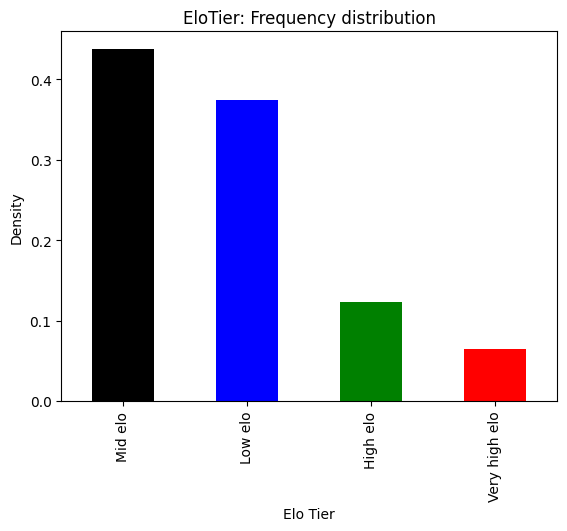

In [267]:
regames_df = pd.DataFrame(games_df['EloTier'])
regames_df['Result'] = games_df['Result']
regames_df['EloTier'].value_counts(normalize = True).plot.bar(color = ['black', 'blue', 'green', 'red'])
regames_df.value_counts()
plt.title('EloTier: Frequency distribution')
plt.xlabel('Elo Tier')
plt.ylabel('Density')
plt.savefig('graphs/frequency_elotier.pdf', bbox_inches = 'tight') 

In [268]:
# Individual dataframes for each group
df_L = regames_df[(regames_df['EloTier'] == 'Low elo')]
df_M = regames_df[(regames_df['EloTier'] == 'Mid elo')]
df_H = regames_df[(regames_df['EloTier'] == 'High elo')]
df_VH = regames_df[(regames_df['EloTier'] == 'Very high elo')]


# Resampling
re_L = resample(df_L, replace = True, n_samples = 1875, random_state = 32158)
re_M = resample(df_M, replace = True, n_samples = 1875, random_state = 32158)
re_H = resample(df_H, replace = True, n_samples = 1875, random_state = 32158)
re_VH = resample(df_VH, replace = True, n_samples = 1875, random_state = 32158)

# Resampled group dataframe
re_regames = pd.concat([re_L, re_M, re_H, re_VH])
re_regames = re_regames.reset_index(drop = True)
re_regames

,EloTier,Result
0,Low elo,Lose
1,Low elo,Win
2,Low elo,Lose
3,Low elo,Lose
4,Low elo,Win
...,...,...
7495,Very high elo,Lose
7496,Very high elo,Lose
7497,Very high elo,Win
7498,Very high elo,Lose


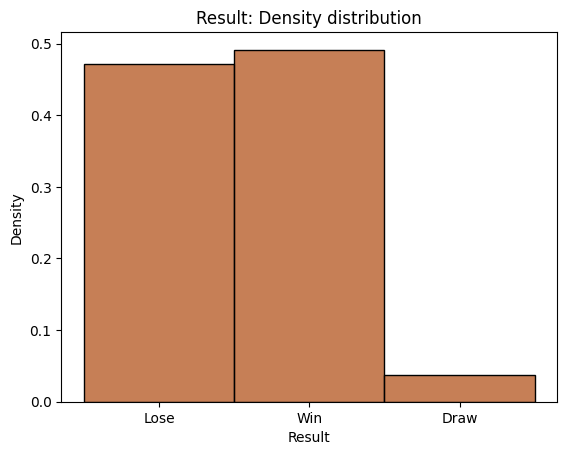

In [269]:
sns.histplot(re_regames['Result'], stat = 'density', color = '#B3541E')
plt.title('Result: Density distribution')
plt.savefig('graphs/result_density.pdf', bbox_inches = 'tight')

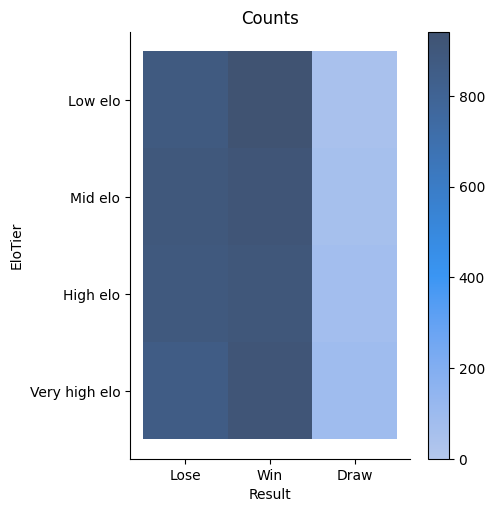

In [270]:
sns.displot(data = re_regames, x = 'Result', y = 'EloTier', cbar = True, color = '#143F6B')
plt.title('Counts')
plt.savefig('graphs/counts_result_elo.pdf', bbox_inches = 'tight')

In [271]:
contingency_games = pd.crosstab(re_regames["EloTier"], re_regames["Result"]) #contingency table
contingency_games

#chi_2 test
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_games)
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)
if p < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

chi2 statistic:     16.013
p-value:            0.013683
degrees of freedom: 6
expected frequencies:
 [[ 69.25923456 884.11788238 921.62288305]
 [ 69.25923456 884.11788238 921.62288305]
 [ 69.25923456 884.11788238 921.62288305]
 [ 69.22229631 883.64635285 921.13135085]]
The null hypothesis is rejected.


## ANOVA test: Result and RatingDiff

Each game is classified in one of the three groups of the variable Result with its respective WhiteRatingDiff value

The WhiteRatingDiff is used since the BlackRatingDiff is the counterpart of the WhiteRatingDiff

WhiteRateDiffs with a negative value are assumed to have a higher probability of being associated with a game loss, on the other hand WhiteRateDiffs with a positive value have a higher probability of being associated with a game win.

$H_0$: There is no substantial relationship between the WhiteRatingDiff and Result variates.

$H_1$: There is a substantial relationship between the WhiteRatingDiff and Result variates.

Result  WhiteRatingDiff
Lose    -10.0              18033
        -11.0              15061
Win      10.0              13937
         11.0              13878
Lose    -9.0               12109
                           ...  
        -250.0                 1
        -249.0                 1
        -248.0                 1
        -247.0                 1
Win      692.0                 1
Length: 764, dtype: int64

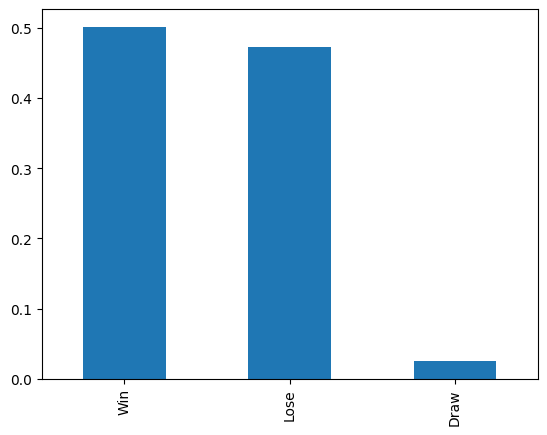

In [272]:
games_WRD = pd.DataFrame(games_df['Result'])
games_WRD['WhiteRatingDiff'] = games_df['WhiteRatingDiff']
games_WRD['Result'].value_counts(normalize = True).plot.bar()
games_WRD.value_counts()

In [273]:
# Individual dataframes for each group
df_Lose = games_WRD[(games_WRD['Result'] == 'Lose')].dropna()
df_Win = games_WRD[(games_WRD['Result'] == 'Win')].dropna()
df_Draw = games_WRD[(games_WRD['Result'] == 'Draw')].dropna()

# Resampling
re_Lose = resample(df_Lose, replace = True, n_samples = 2500, random_state = 58963)
re_Win = resample(df_Win, replace = True, n_samples = 2500, random_state = 58963)
re_Draw = resample(df_Draw, replace = True, n_samples = 2500, random_state = 58963)

# Resampled group dataframe
re_games_WRD = pd.concat([re_Lose, re_Win, re_Draw])
re_games_WRD = re_games_WRD.reset_index(drop = True)
re_games_WRD

,Result,WhiteRatingDiff
0,Lose,-11.0
1,Lose,-15.0
2,Lose,-14.0
3,Lose,-10.0
4,Lose,-10.0
...,...,...
7495,Draw,0.0
7496,Draw,-1.0
7497,Draw,-2.0
7498,Draw,1.0


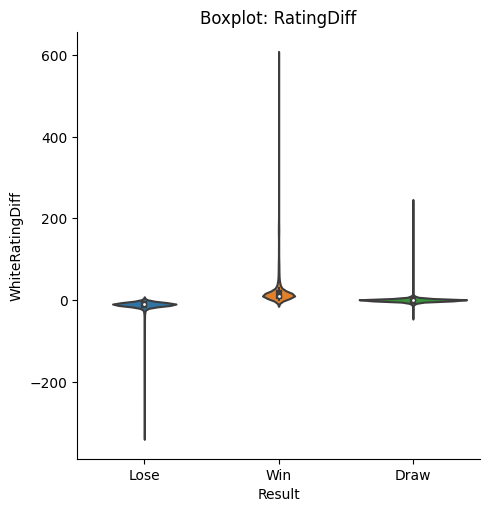

In [274]:
sns.catplot(data = re_games_WRD, x = 'Result', y = 'WhiteRatingDiff', kind = 'violin')
plt.title('Boxplot: RatingDiff')
plt.savefig('graphs/rating_diff_catplot.pdf', bbox_inches = 'tight')

In [275]:
# Grouping
groups = re_games_WRD.groupby('Result').groups
Lose = re_games_WRD['WhiteRatingDiff'][groups['Lose']]
Win = re_games_WRD['WhiteRatingDiff'][groups['Win']]
Draw = re_games_WRD['WhiteRatingDiff'][groups['Draw']]

#log transformation
Lose_log = np.log(Lose + 334)
Win_log = np.log(Win + 334)
Draw_log = np.log(Draw + 334)
 
# ANOVA
f_stat, p_value = stats.f_oneway(Lose_log, Win_log, Draw_log)
print('F statistic = {}'.format(f_stat))
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

F statistic = 808.9777309987919
p-value = 7.5145e-319
The null hypothesis is rejected.


## A/B test: Does color matter? (Binomial test)

In [276]:
from scipy.stats import binom_test

games_bin = pd.DataFrame(games_df['Result'].replace({ 'Draw': np.NAN }))
games_bin

,Result
0,Lose
1,Lose
2,Win
3,Lose
4,Win
...,...
199995,Lose
199996,Win
199997,Win
199998,Lose


In [277]:
# Resampling
n_samples = 150000
resample_bin = resample(games_bin['Result'], replace = True, n_samples = n_samples, random_state = 60785)

# Resampled dataframe
re_games_bin = resample_bin.reset_index(drop = True)
re_games_bin = pd.DataFrame(re_games_bin)
re_games_bin_count = re_games_bin.value_counts()
re_games_bin_count = pd.DataFrame(re_games_bin_count)
victories = re_games_bin_count.iloc[['0']]
re_games_bin_count

,0
Result,
Win,75515
Lose,70689


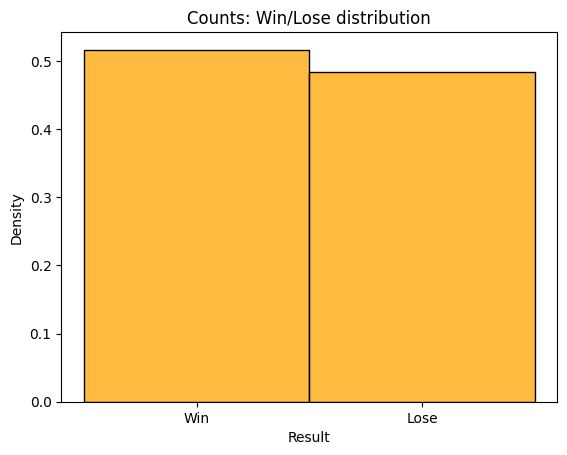

In [278]:
sns.histplot(re_games_bin['Result'], stat = 'density',color = 'orange')
plt.title('Counts: Win/Lose distribution')
plt.savefig('graphs/distribution_winlose.pdf', bbox_inches = 'tight')

In [279]:
# Binomial test
p_value = stats.binom_test(x = victories , n=n_samples, p = 1/2, alternative= 'greater')
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

p-value = [0.00394343]
The null hypothesis is rejected.
